In [147]:
#Importar librerias

import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import seaborn as sns
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.metrics import average_precision_score
from sklearn.svm import OneClassSVM
from sklearn.ensemble import IsolationForest
from sklearn.metrics import f1_score, recall_score, precision_score, make_scorer, confusion_matrix, classification_report
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
import os
     
df=pd.read_csv('data.csv')
df.head()
df

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.00,160296.36,M1979787155,0.00,0.00,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.00,19384.72,M2044282225,0.00,0.00,0,0
2,1,TRANSFER,181.00,C1305486145,181.00,0.00,C553264065,0.00,0.00,1,0
3,1,CASH_OUT,181.00,C840083671,181.00,0.00,C38997010,21182.00,0.00,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.00,29885.86,M1230701703,0.00,0.00,0,0
...,...,...,...,...,...,...,...,...,...,...,...
6362615,743,CASH_OUT,339682.13,C786484425,339682.13,0.00,C776919290,0.00,339682.13,1,0
6362616,743,TRANSFER,6311409.28,C1529008245,6311409.28,0.00,C1881841831,0.00,0.00,1,0
6362617,743,CASH_OUT,6311409.28,C1162922333,6311409.28,0.00,C1365125890,68488.84,6379898.11,1,0
6362618,743,TRANSFER,850002.52,C1685995037,850002.52,0.00,C2080388513,0.00,0.00,1,0


Estructura del conjunto de datos

paso: representa una unidad de tiempo en el mundo real, donde 1 paso equivale a 1 hora. La simulación total abarca 744 pasos, equivalente a 30 días.

tipo: Los tipos de transacciones incluyen ENTRADA DE EFECTIVO, SALIDA DE EFECTIVO, DÉBITO, PAGO y TRANSFERENCIA.
importe: El importe de la transacción en la moneda local.

nameOrig: el cliente que inicia la transacción.

oldbalanceOrg: el saldo inicial antes de la transacción.

newbalanceOrig: El nuevo saldo después de la transacción.

nameDest: el cliente destinatario de la transacción.

oldbalanceDest: el saldo del destinatario inicial antes de la transacción. No aplica para clientes identificados con 'M' (Comerciantes).

newbalanceDest: el saldo del nuevo destinatario después de la transacción. No aplica para 'M' (Comerciantes).

isFraud: Identifica transacciones realizadas por agentes fraudulentos con el objetivo de agotar las cuentas de los clientes mediante transferencias y retiros de efectivo.

isFlaggedFraud: señala transferencias no autorizadas a gran escala entre cuentas, y cualquier transacción que supere las 200 000 se considera ilegal.

Gestión del fraude
Las instituciones financieras están expuestas a diferentes tipos de fraude que ocasionan millones en pérdidas. Para detectar y prevenir el fraude se usan herramientas de análisis predictivo como hemos visto en artículos anteriores. Los datos de comportamientos fraudulentos presentan correlaciones al cruzarlos con diversas fuentes y es gracias a estas herramientas cuando podemos descubrir patrones y actividades sospechosas. Las soluciones de big data para análisis de fraude correlacionan datos como geolocalización, patrones de compras, datos transaccionales históricos y otras fuentes de datos tanto internas como externas para detectar el fraude en tarjetas de crédito. Son soluciones que necesitan operar en tiempo real utilizando tecnologías en memoria para analizar cientos de terabytes de datos de transacciones en tiempo real para detección del fraude.

In [4]:
"Deteccion de valores nulos"
df.isnull().values.any()

False

In [12]:
df[["type",
    "amount",
    "oldbalanceOrg",
    "newbalanceOrig",
    "oldbalanceDest",
    "newbalanceDest",
    'isFraud']].groupby(["type","isFraud"]).agg(['count','mean'])


amount               oldbalanceOrg                \
                    count          mean         count          mean   
type     isFraud                                                      
CASH_IN  0        1399284  1.689202e+05       1399284  3.590464e+06   
CASH_OUT 0        2233384  1.739172e+05       2233384  4.342923e+04   
         1           4116  1.455103e+06          4116  1.453869e+06   
DEBIT    0          41432  5.483665e+03         41432  6.864734e+04   
PAYMENT  0        2151495  1.305760e+04       2151495  6.821683e+04   
TRANSFER 0         528812  9.062290e+05        528812  4.055876e+04   
         1           4097  1.480892e+06          4097  1.846374e+06   

                 newbalanceOrig               oldbalanceDest                \
                          count          mean          count          mean   
type     isFraud                                                             
CASH_IN  0              1399284  3.759379e+06        1399284  1.587919e+06   
CASH_OUT 0              2233384  1.750626e+04        2233384  1.498519e+06   
         1                 4116  7.258688e+01           4116  1.084918e+06   
DEBIT    0                41432  6.516165e+04          41432  1.493136e+06   
PAYMENT  0              2151495  6.183789e+04        2151495  0.000000e+00   
TRANSFER 0               528812  7.380372e+03         528812  2.587490e+06   
         1                 4097  3.856046e+05           4097  1.073383e+03   

                 newbalanceDest                
                          count          mean  
type     isFraud                               
CASH_IN  0              1399284  1.467105e+06  
CASH_OUT 0              2233384  1.689744e+06  
         1                 4116  2.549545e+06  
DEBIT    0                41432  1.513003e+06  
PAYMENT  0              2151495  0.000000e+00  
TRANSFER 0               528812  3.582075e+06  
         1                 4097  3.981411e+03

In [22]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


<Axes: xlabel='type', ylabel='isFraud'>

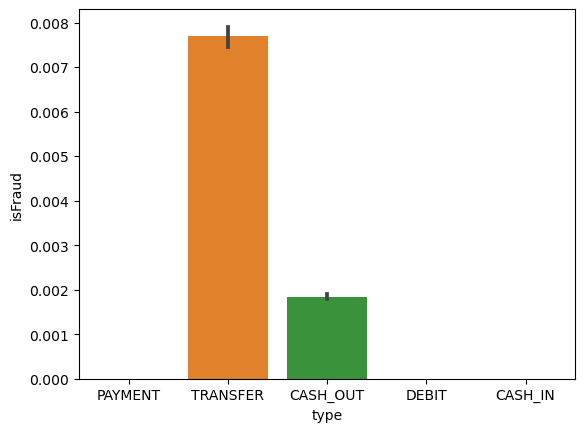

In [28]:
sns.barplot(x = "type", y = "isFraud", data = df)


Con esta imagen podemos ver que los fraudes encontrados son realizados por Transferencia y Retiro de dinero.


In [29]:
print('\n El tipo de transacciones fraudulentas son {}'.format(\
list(df.loc[df.isFraud == 1].type.drop_duplicates().values)))

dfFraudTransfer = df.loc[(df.isFraud == 1) & (df.type == 'TRANSFER')]
dfFraudCashout = df.loc[(df.isFraud == 1) & (df.type == 'CASH_OUT')]

print ('\n El número de TRANSFER fraudulentas = {}'.\
       format(len(dfFraudTransfer))) # 4097

print ('\n El número de CASH_OUTs fraudulentas = {}'.\
       format(len(dfFraudCashout))) # 4116


 El tipo de transacciones fraudulentas son ['TRANSFER', 'CASH_OUT']

 El número de TRANSFER fraudulentas = 4097

 El número de CASH_OUTs fraudulentas = 4116


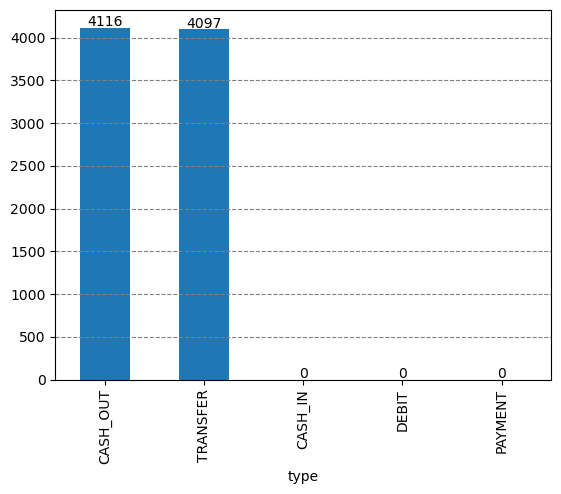

In [34]:
ax = df.groupby('type').agg(total_sale = ('isFraud', 'sum')).sort_values(by='total_sale', ascending=False).plot(kind="bar")
for p in ax.patches:
    ax.annotate(np.round(p.get_height(),decimals=2), (p.get_x()+p.get_width()/2., p.get_height()), ha='center', va='center', xytext=(0, 4), textcoords='offset points')
ax.get_legend().remove()
ax.grid(axis = 'y', color = 'gray', linestyle = 'dashed')

In [36]:
df.isFraud.info()


<class 'pandas.core.series.Series'>
RangeIndex: 6362620 entries, 0 to 6362619
Series name: isFraud
Non-Null Count    Dtype
--------------    -----
6362620 non-null  int64
dtypes: int64(1)
memory usage: 48.5 MB


In [56]:
df["isFraud"].value_counts()


isFraud
0    6354407
1       8213
Name: count, dtype: int64

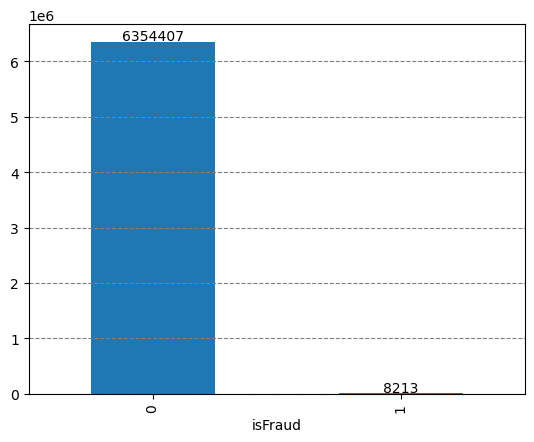

In [86]:
ax = df["isFraud"].value_counts().plot(kind="bar")
for p in ax.patches:
    ax.annotate(np.round(p.get_height(),decimals=1), (p.get_x()+p.get_width()/2., p.get_height()), ha='center', va='center', xytext=(0, 4), textcoords='offset points')
ax.grid(axis = 'y', color = 'gray', linestyle = 'dashed')


Ahora buscaremos que tipo de transaccion podria ser fraudulenta 

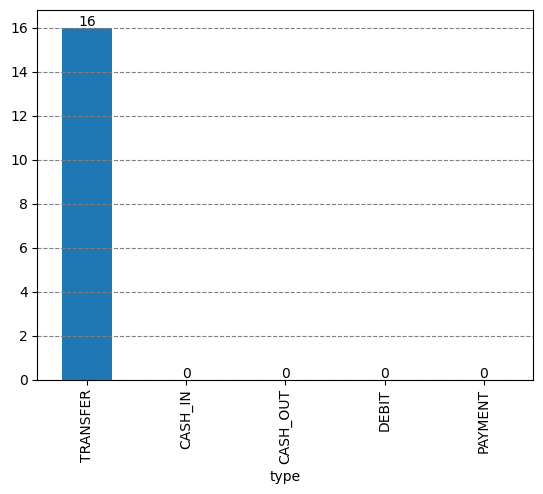

In [41]:
ax = df.groupby('type').agg(total_sale = ('isFlaggedFraud', 'sum')).sort_values(by='total_sale', ascending=False).plot(kind="bar")
for p in ax.patches:
    ax.annotate(np.round(p.get_height(),decimals=2), (p.get_x()+p.get_width()/2., p.get_height()), ha='center', va='center', xytext=(0, 4), textcoords='offset points')
ax.get_legend().remove()
ax.grid(axis = 'y', color = 'gray', linestyle = 'dashed')

Considerando el numero total de transacciones, podemos ver que no afecta esta variable. Se puede eliminar 

In [51]:
print('Hay comerciantes entre las cuentas originales de la transacciones CASH_IN? {}'.format(\
(df.loc[df.type == 'CASH_IN'].nameOrig.str.contains('M')).any())) 
     

Hay comerciantes entre las cuentas originales de la transacciones CASH_IN? False


In [52]:
print('Hay comerciantes entre las cuentas originales de la transacciones CASH_OUT? {}'.format(\
(df.loc[df.type == 'CASH_OUT'].nameOrig.str.contains('M')).any())) 

Hay comerciantes entre las cuentas originales de la transacciones CASH_OUT? False


Teniendo en cuenta el análisis anterior, solo se tendrá en cuenta los tipos de transacciones: TRANSFER y CASH_OUT



In [71]:
Limpio = df.loc[(df.type == 'TRANSFER') | (df.type == 'CASH_OUT')]
Limpio

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
2,1,TRANSFER,181.00,C1305486145,181.00,0.0,C553264065,0.00,0.00,1,0
3,1,CASH_OUT,181.00,C840083671,181.00,0.0,C38997010,21182.00,0.00,1,0
15,1,CASH_OUT,229133.94,C905080434,15325.00,0.0,C476402209,5083.00,51513.44,0,0
19,1,TRANSFER,215310.30,C1670993182,705.00,0.0,C1100439041,22425.00,0.00,0,0
24,1,TRANSFER,311685.89,C1984094095,10835.00,0.0,C932583850,6267.00,2719172.89,0,0
...,...,...,...,...,...,...,...,...,...,...,...
6362615,743,CASH_OUT,339682.13,C786484425,339682.13,0.0,C776919290,0.00,339682.13,1,0
6362616,743,TRANSFER,6311409.28,C1529008245,6311409.28,0.0,C1881841831,0.00,0.00,1,0
6362617,743,CASH_OUT,6311409.28,C1162922333,6311409.28,0.0,C1365125890,68488.84,6379898.11,1,0
6362618,743,TRANSFER,850002.52,C1685995037,850002.52,0.0,C2080388513,0.00,0.00,1,0


Eliminamos las variables que consideramos que son menos significativas



In [72]:
Limpio = Limpio.drop(['nameOrig', 'nameDest', 'isFlaggedFraud'], axis = 1)
Limpio

,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud
2,1,TRANSFER,181.00,181.00,0.0,0.00,0.00,1
3,1,CASH_OUT,181.00,181.00,0.0,21182.00,0.00,1
15,1,CASH_OUT,229133.94,15325.00,0.0,5083.00,51513.44,0
19,1,TRANSFER,215310.30,705.00,0.0,22425.00,0.00,0
24,1,TRANSFER,311685.89,10835.00,0.0,6267.00,2719172.89,0
...,...,...,...,...,...,...,...,...
6362615,743,CASH_OUT,339682.13,339682.13,0.0,0.00,339682.13,1
6362616,743,TRANSFER,6311409.28,6311409.28,0.0,0.00,0.00,1
6362617,743,CASH_OUT,6311409.28,6311409.28,0.0,68488.84,6379898.11,1
6362618,743,TRANSFER,850002.52,850002.52,0.0,0.00,0.00,1


In [73]:
Limpio.loc[Limpio.type == 'TRANSFER', 'type'] = 0
Limpio.loc[Limpio.type == 'CASH_OUT', 'type'] = 1
Limpio.type = Limpio.type.astype(int) 

Limpio

,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud
2,1,0,181.00,181.00,0.0,0.00,0.00,1
3,1,1,181.00,181.00,0.0,21182.00,0.00,1
15,1,1,229133.94,15325.00,0.0,5083.00,51513.44,0
19,1,0,215310.30,705.00,0.0,22425.00,0.00,0
24,1,0,311685.89,10835.00,0.0,6267.00,2719172.89,0
...,...,...,...,...,...,...,...,...
6362615,743,1,339682.13,339682.13,0.0,0.00,339682.13,1
6362616,743,0,6311409.28,6311409.28,0.0,0.00,0.00,1
6362617,743,1,6311409.28,6311409.28,0.0,68488.84,6379898.11,1
6362618,743,0,850002.52,850002.52,0.0,0.00,0.00,1


Verificamos que ninguna variable tenga desviación estándar cero:

In [74]:
Limpio.std(axis=0)

step              1.416191e+02
type              3.941525e-01
amount            8.877897e+05
oldbalanceOrg     2.513251e+05
newbalanceOrig    1.512558e+05
oldbalanceDest    4.225550e+06
newbalanceDest    4.676990e+06
isFraud           5.436687e-02
dtype: float64

Tomamos la decisión de realizar el modelamiento teniendo en cuenta sólo estos tipos de transacción, de esta manera pasamos de tener 6 millones de transacciones a 2,7 millones

In [75]:
Limpio["isFraud"].value_counts()


isFraud
0    2762196
1       8213
Name: count, dtype: int64

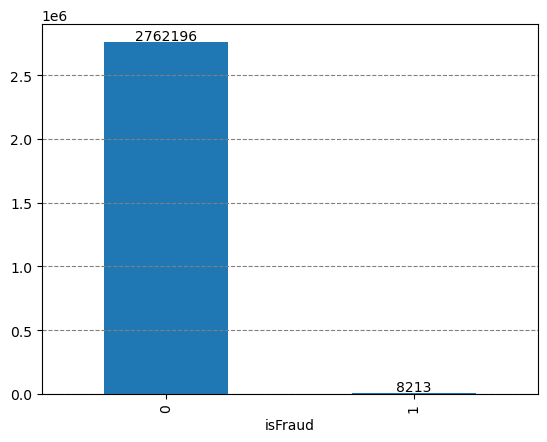

In [76]:
ax = Limpio["isFraud"].value_counts().plot(kind="bar")
for p in ax.patches:
    ax.annotate(np.round(p.get_height(),decimals=2), (p.get_x()+p.get_width()/2., p.get_height()), ha='center', va='center', xytext=(0, 4), textcoords='offset points')
ax.grid(axis = 'y', color = 'gray', linestyle = 'dashed')


Matriz de correlación

In [77]:
Limpio.corr()

,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud
step,1.000000,-0.016022,0.037007,0.005744,-0.011280,0.037778,0.037475,0.048671
type,-0.016022,1.000000,-0.326040,-0.013202,0.018726,-0.099794,-0.157024,-0.042400
amount,0.037007,-0.326040,1.000000,0.120389,0.018296,0.307133,0.497027,0.070660
oldbalanceOrg,0.005744,-0.013202,0.120389,1.000000,0.778826,-0.020403,-0.010029,0.347582
newbalanceOrig,-0.011280,0.018726,0.018296,0.778826,1.000000,-0.012277,-0.015439,0.063557
oldbalanceDest,0.037778,-0.099794,0.307133,-0.020403,-0.012277,1.000000,0.970060,-0.014960
newbalanceDest,0.037475,-0.157024,0.497027,-0.010029,-0.015439,0.970060,1.000000,-0.008978
isFraud,0.048671,-0.042400,0.070660,0.347582,0.063557,-0.014960,-0.008978,1.000000


<Axes: >

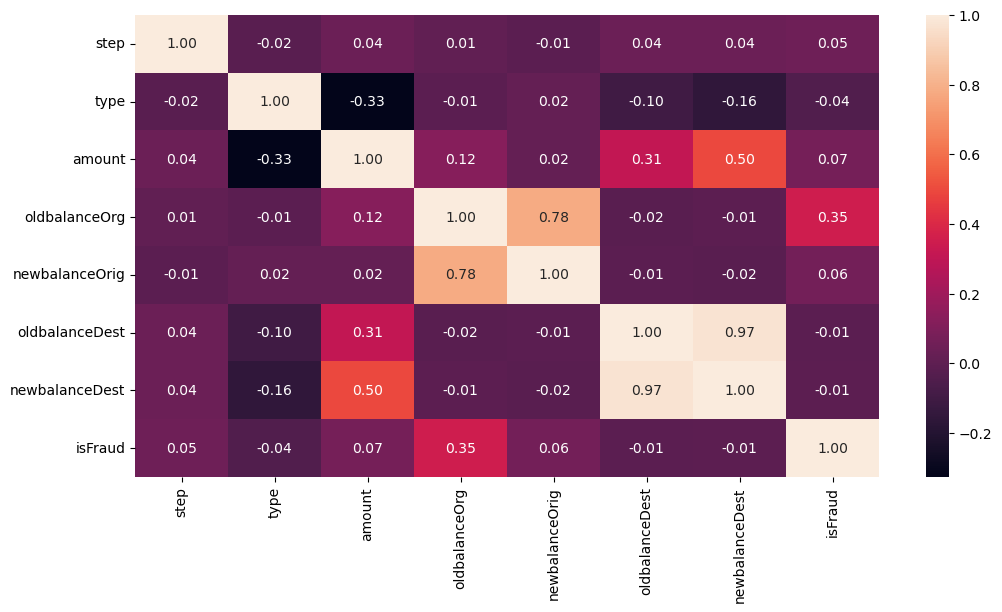

In [87]:
f, ax = plt.subplots(figsize=(12,6))
sns.heatmap(Limpio.corr(), annot=True, fmt='.2f')

Cambiar el tipo de datos



In [88]:

Limpio['Hour'] = Limpio['step'] % 24

Limpio['Hour'] = Limpio['Hour'].astype('object')

Revisamos de esta manera también el comportamiento de la variable Step (Asigna una unidad de tiempo en el mundo real. Representa la hora y fecha en la que se realizó la transacción), esta variable fue transformada para entender el comportamiento de las transacciones de fraude y revisar en qué franjas se están presentando más eventos


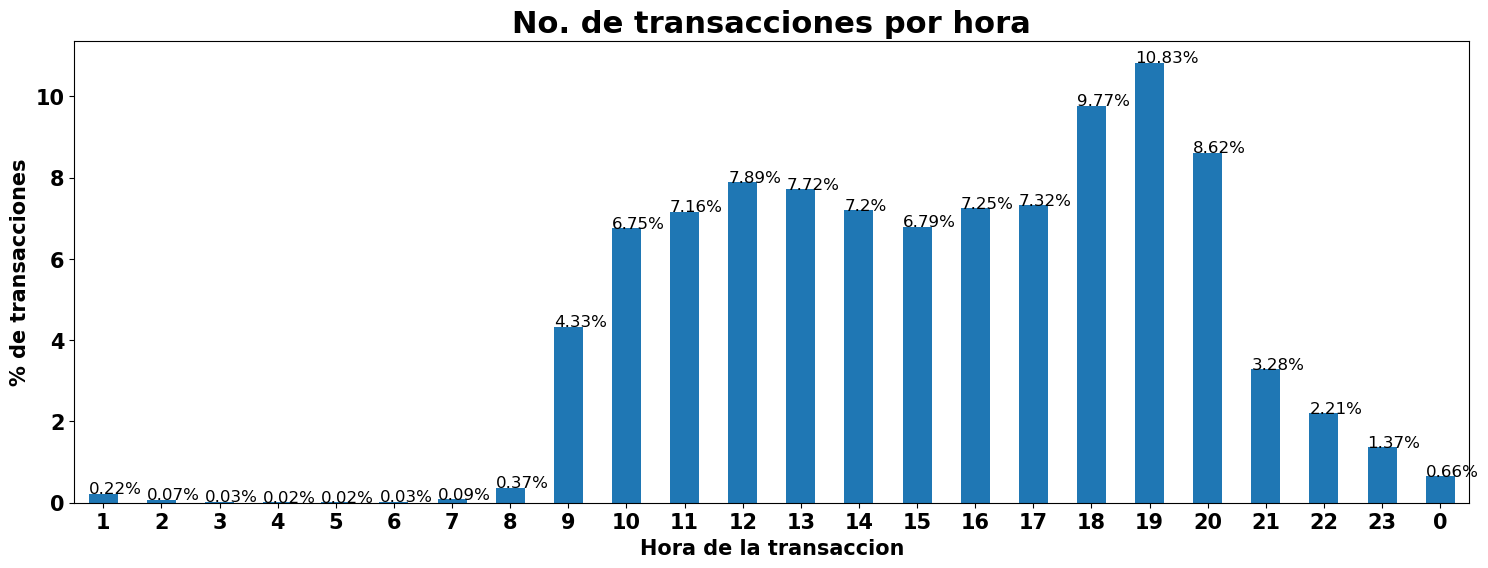

In [90]:

plt.figure(figsize=(18,6))
ax = (Limpio['Hour'].value_counts(sort=False, normalize=True) * 100).round(2).plot(kind='bar')
for i in ax.patches:
    ax.text(i.get_x(), i.get_height(), str(round(i.get_height(), 2)) + "%", fontsize=12, color='black')
plt.xlabel('Hora de la transaccion', fontsize=15, fontweight='bold')
plt.xticks(fontsize=15, fontweight='bold', rotation=0)
plt.ylabel('% de transacciones', fontsize=15, fontweight='bold')
plt.yticks(fontsize=15, fontweight='bold')
plt.title('No. de transacciones por hora', fontsize=22, fontweight='bold')
plt.show()
     

In [93]:
Limpio_fraude = Limpio.loc[X.isFraud == 1]
Limpio_fraude.head()

,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,Hour
2,1,0,181.0,181.0,0.0,0.0,0.0,1,1
3,1,1,181.0,181.0,0.0,21182.0,0.0,1,1
251,1,0,2806.0,2806.0,0.0,0.0,0.0,1,1
252,1,1,2806.0,2806.0,0.0,26202.0,0.0,1,1
680,1,0,20128.0,20128.0,0.0,0.0,0.0,1,1


Número de transacciones fraudulentas por hora



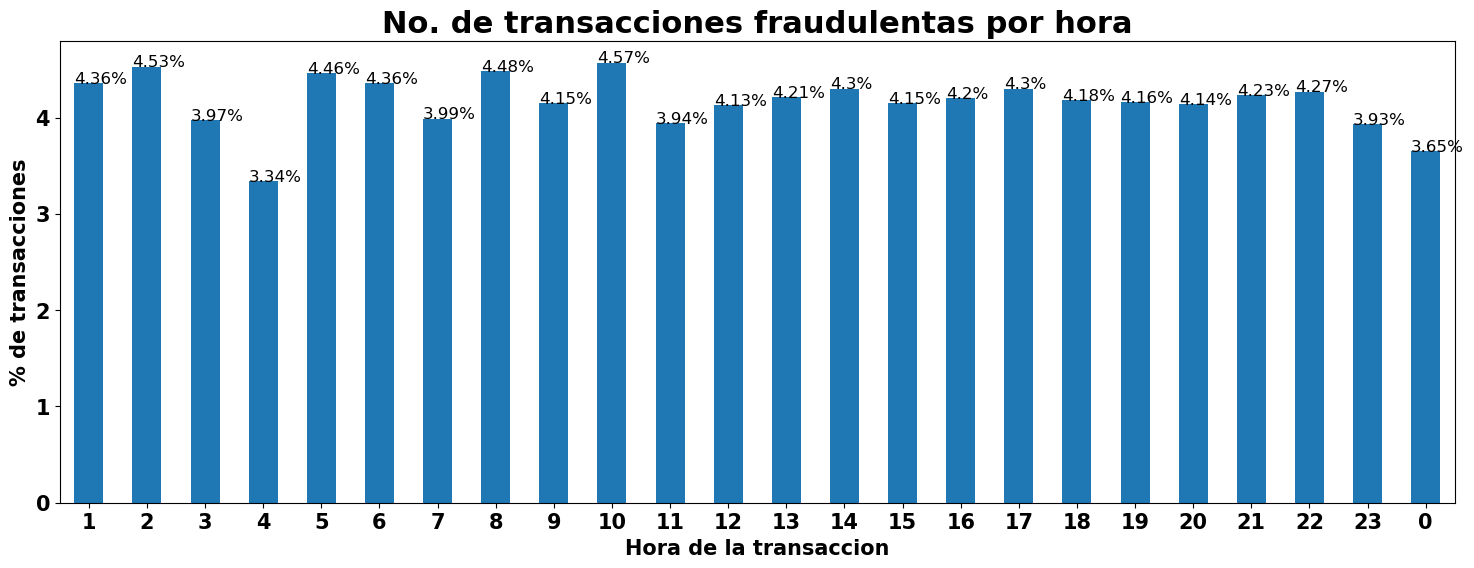

In [94]:

plt.figure(figsize=(18,6))
ax = (Limpio_fraude['Hour'].value_counts(sort=False, normalize=True) * 100).round(2).plot(kind='bar')
for i in ax.patches:
    ax.text(i.get_x(), i.get_height(), str(round(i.get_height(), 2)) + "%", fontsize=12, color='black')
plt.xlabel('Hora de la transaccion', fontsize=15, fontweight='bold')
plt.xticks(fontsize=15, fontweight='bold', rotation=0)
plt.ylabel('% de transacciones', fontsize=15, fontweight='bold')
plt.yticks(fontsize=15, fontweight='bold')
plt.title('No. de transacciones fraudulentas por hora', fontsize=22, fontweight='bold')
plt.show()

Dispersión sobre la variable: oldbalanceOrg por tipo de transacción, TRANSFER = 0, CASH_OUT = 1



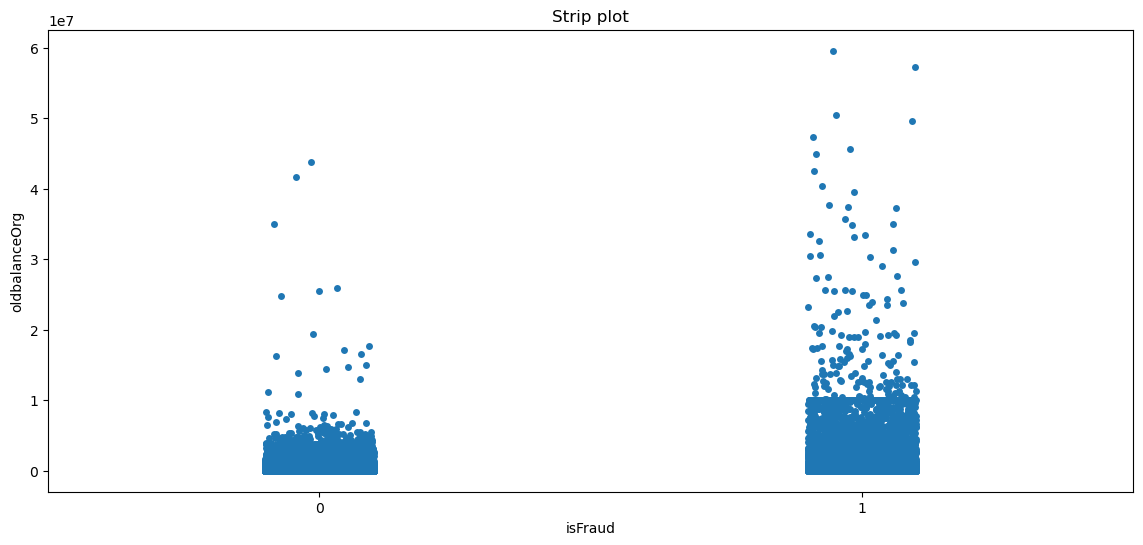

In [100]:

fig, ax= plt.subplots(figsize=(14, 6))  
sns.stripplot(x= Limpio['isFraud'], y=Limpio['oldbalanceOrg'], jitter=True, ax=ax)  
ax.set_title('Strip plot')  
plt.show() 
     

Aplicación de modelos


In [159]:

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import StratifiedShuffleSplit, train_test_split, GridSearchCV, StratifiedKFold 
from sklearn.pipeline import Pipeline
from sklearn import svm
from sklearn.svm import OneClassSVM
import matplotlib.pyplot as plt
from sklearn.covariance import EllipticEnvelope
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
     

In [114]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X.drop(['isFraud'], axis = 1), X['isFraud'],
                                                    random_state=0, test_size=0.3, stratify=X['isFraud'])

In [115]:
skf = StratifiedKFold(n_splits=3)


In [116]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

X_train_n = scaler.fit_transform(X_train)
X_test_n = scaler.fit_transform(X_test)

Modelo 1: LogisticRegression



Este modelo clasifica las instancias según la probabilidad de pertenecer a alguno de los
valores de la variable respuesta, siempre encontrándose en la franja de 0 ó 1.
En nuestro caso se incluye el parámetro weight = “balanced” y con esto el algoritmo se
encargará de equilibrar a la clase minoritaria durante el entrenamiento.

In [117]:

clf = LogisticRegression(class_weight='balanced')
grid_values = {'penalty': ['l2'],'C':[0.001,0.01,0.8]}
grid_clf = GridSearchCV(clf, param_grid = grid_values, cv=skf, scoring = 'recall')

In [119]:
grid_clf.fit(X_train_n, y_train)


GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=None, shuffle=False),
             estimator=LogisticRegression(class_weight='balanced'),
             param_grid={'C': [0.001, 0.01, 0.8], 'penalty': ['l2']},
             scoring='recall')

Después de aplicar el GridSearch obtenemos que los mejores hiperparámetros para el
modelo, han sido con una regularización L2, más penalización de 0.8

In [149]:

model = grid_clf.best_estimator_
model
     

LogisticRegression(C=0.8, class_weight='balanced')

In [150]:
scores = cross_val_score(model, X_train_n, y_train, cv=skf, scoring="accuracy")
scores
     

array([0.94102523, 0.93993927, 0.93995   ])

In [160]:

pred = model.predict(X_test_n)
print(confusion_matrix(y_test, pred))
     

[[781511  47148]
 [   283   2181]]


In [163]:
print(classification_report(y_test, pred))


              precision    recall  f1-score   support

           0       1.00      0.94      0.97    828659
           1       0.04      0.89      0.08      2464

    accuracy                           0.94    831123
   macro avg       0.52      0.91      0.53    831123
weighted avg       1.00      0.94      0.97    831123



Se evidencia que el modelo acierta 2201 muestras y falla en 263, dando un recall
(sensibilidad) de 0.89, adicional se nota que la métrica f1-score es muy baja, en este punto
es cuando nos debemos preguntar qué es mejor para el negocio y para la empresa
financiera, tener que revisar los falsos positivos manualmente o fallar en la detección de los
verdaderos casos de fraude. Teniendo en cuenta la baja precisión que existe en relación
con una alta sensibilidad, se puede evidenciar una buena detección de la clase objetivo,
pero se está incluyendo muestras de la otra clase.
El riesgo de este caso se puede ver reflejado en la satisfacción del cliente, ya que se está
tomando como falso positivo 46595 transacciones; y en el tiempo dedicado por los analistas
para validar dichos casos, sin embargo, es el modelo que mejor detecta los fraudes. 